<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta pràctica aprendrem a detectar la intenció de l'usuari a partir d'interaccions reals amb un xatbot. En el context de xatbots, la classificació d'intencions ajuda a entendre quina acció o resposta hauria de prendre el sistema en funció de la consulta de l'usuari.  


<p> ✨ <b>Contingut</b>: en primer lloc, farem servir una base de dades amb oracions d'interaccions en espanyol etiquetades com 19 intencions diferents. En segon lloc, realitzarem el preprocessament de les dades, és a dir, transformarem les dades perquè tinguen un format adequat per a ser introduïdes al model. I finalment, dissenyarem i entrenarem el model de classificació per detectar automàticament la intenció de les oracions.</p>  


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>



---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [74]:
import random
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization,Bidirectional #Remove
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score 
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

import time  

import nltk
import pandas as pd
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lukag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lukag\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: c:\Users\lukag\OneDrive\Desktop\Universidad\3ero\cuadrimestre1\TVD\TVD_Practica_2\nlu_ATIS_data.tar.gz

  0%|          | 0.00/122k [00:00<?, ?B/s]
100%|██████████| 122k/122k [00:00<00:00, 531kB/s]
100%|██████████| 122k/122k [00:00<00:00, 531kB/s]


<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [25]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


Per a aquesta primera part de la pràctica ens centrarem en la primera columna dels arxius que correspon amb les **oracions** en anglès introduïdes per l'usuari. I en la tercera columna que correspon amb la **intenció** de cada oració, és a dir, cada oració tindrà una etiqueta.

Podeu executar la cel·la següent tantes vegades com vulgueu per veure instàncies d'aquest conjunt de dades.


In [26]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[2])
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Sentence:  list all the flights that fly into general mitchell international
Intent:  flight


A continuació analitzarem quantes etiquetes diferents hi ha al dataset i quines són.

In [27]:
num_labels = 0
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels')

Label 0: ground_service
Label 1: airline
Label 2: restriction
Label 3: ground_service+ground_fare
Label 4: capacity
Label 5: cheapest
Label 6: airfare+flight_time
Label 7: city
Label 8: quantity
Label 9: airfare
Label 10: abbreviation
Label 11: ground_fare
Label 12: flight
Label 13: flight+airfare
Label 14: aircraft+flight+flight_no
Label 15: distance
Label 16: airport
Label 17: flight_no
Label 18: airline+flight_no
Label 19: flight_time
Label 20: meal
Label 21: aircraft

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [28]:
num_words=500
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index
print(vocab)

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentenes` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [29]:

train_sequences = tokenizer.texts_to_sequences(train_sentences)

print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [30]:
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12  69   1  38   2   9  64 415  84
  17  75  16  13  64 493  16   4  36]


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [31]:
#TODO
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding. Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [32]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot.

In [33]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [34]:
def preprocess_sentences(sentences, tokenizer, max_sequence_length):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return padded_sequences

In [35]:
def preprocess_labels(labels, label_encoder):

    numerical_labels = label_encoder.transform(labels)
    one_hot_labels = to_categorical(numerical_labels, num_classes)
    return one_hot_labels

In [36]:

val_pad_sequences = preprocess_sentences(val_data[0], tokenizer, max_sequence_length)
test_pad_sequences = preprocess_sentences(test_data[0], tokenizer, max_sequence_length)


In [37]:
val_labels = list(s.replace('"', '') for s in val_data[2])
val_labels = list(s.replace(' ', '') for s in val_labels)

test_labels = list(s.replace('"', '') for s in test_data[2])
test_labels = list(s.replace(' ', '') for s in test_labels)

def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']
val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)


In [38]:
val_encoded_labels = preprocess_labels(val_labels, label_encoder)
test_encoded_labels = preprocess_labels(test_labels, label_encoder)

---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [39]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [40]:
test_sentences = list(test_data[0])

# funcion para listar las predicciones incorrectas
def incorrect_predictions(model, test_pad_sequences, test_labels, test_sentences):
    probs = model.predict(test_pad_sequences)
    _predicted_labels = np.argmax(probs, axis=1)
    predicted_labels = label_encoder.inverse_transform(_predicted_labels)

    for i in range(0, len(predicted_labels)):
        if test_labels[i] != predicted_labels[i]:
            print('Sentence: ', test_sentences[i])
            print('Original label: ', test_labels[i])
            print('Predicted label: ', predicted_labels[i])
            print()

    return None

# funcion para graficar el accuracy
def plot_accuracy(history):
    """
    Función para graficar el accuracy de entrenamiento y validación.
    
    Argumentos:
    - history: El historial del entrenamiento devuelto por 'model.fit()'.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6))
    sns.lineplot(x=epochs_range, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs_range, y=val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

def plot_f1_score(history):
    """
    Función para graficar el f1_score de entrenamiento y validación.
    
    Argumentos:
    - history: El historial del entrenamiento devuelto por 'model.fit()'.
    """
    f1_score = history.history['f1_score']
    val_f1_score = history.history['val_f1_score']
    epochs_range = range(1, len(f1_score) + 1)

    plt.figure(figsize=(8, 6))
    sns.lineplot(x=epochs_range, y=f1_score, label='Training f1_score')
    sns.lineplot(x=epochs_range, y=val_f1_score, label='Validation f1_score')
    plt.xlabel('Epoch')
    plt.ylabel('f1_score')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# funcion para graficar el loss
def plot_loss(history):
    """
    Función para graficar el loss de entrenamiento y validación.
    
    Argumentos:
    - history: El historial del entrenamiento devuelto por 'model.fit()'.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 6))
    sns.lineplot(x=epochs_range, y=loss, label='Training Loss')
    sns.lineplot(x=epochs_range, y=val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()



In [41]:
# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    start_from_epoch=20
)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6635 - loss: 1.8290 - val_accuracy: 0.7244 - val_loss: 0.9218
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8010 - loss: 0.7515 - val_accuracy: 0.8733 - val_loss: 0.5579
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8817 - loss: 0.4488 - val_accuracy: 0.8922 - val_loss: 0.4283
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9063 - loss: 0.3212 - val_accuracy: 0.9044 - val_loss: 0.3553
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9220 - loss: 0.2727 - val_accuracy: 0.9178 - val_loss: 0.3072
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9450 - loss: 0.1888 - val_accuracy: 0.9367 - val_loss: 0.2560
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9554 - loss: 0.1613 - val_accuracy: 0.9400 - val_loss: 0.2399
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.1168 - val_accu

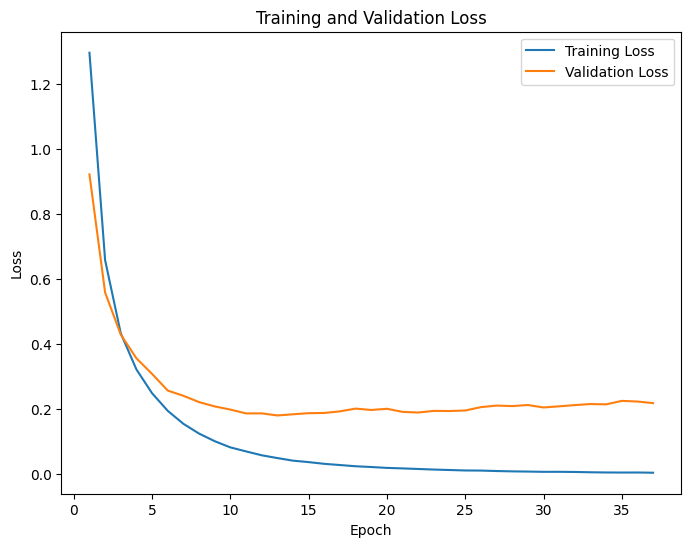

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Val F1 score: 0.7347403750833242
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test F1 score: 0.6843449748179853


In [42]:
embedding_dim = 100
vocab_size = num_words + 1 # 0 is reserved for unknown words

model = Sequential()
model.add(Embedding( vocab_size,embedding_dim)) #layer 1
model.add(GlobalMaxPooling1D()) #layer 2
model.add(Dense(64, activation='relu')) #layer 3
model.add(Dense(22,activation='softmax')) #layer 4

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 200
history = model.fit(train_pad_sequences, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_encoded_labels), callbacks=[early_stopping])

plot_loss(history)


#usar f1_score de sklearn
probs = model.predict(val_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(val_labels, predicted_labels, average='macro')
print(f'Val F1 score: {f1_score1}')

# Print the results f1_score for the test set
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score2 = f1_score(test_labels, predicted_labels, average='macro')
print(f'Test F1 score: {f1_score2}')


Podeu veure a continuació les oracions que el model ha classificat incorrectament.

In [43]:
test_sentences = list(test_data[0])

probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)

for i in range(0, len(predicted_labels)):
  if test_labels[i] != predicted_labels[i]:
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sentence:  show flight and prices kansas city to chicago on next wednesday arriving in chicago by 7 pm
Original label:  flight+airfare
Predicted label:  flight

Sentence:  i need a flight from tampa to milwaukee
Original label:  meal
Predicted label:  flight

Sentence:  i need a flight from milwaukee to seattle
Original label:  meal
Predicted label:  flight

Sentence:  please find a flight from orlando to kansas city
Original label:  airport
Predicted label:  ground_service

Sentence:  which flights are available from san jose to nashville leaving in the morning on april twenty three
Original label:  airline
Predicted label:  flight

Sentence:  what is the latest flight from baltimore to oakland that serves dinner
Original label:  city
Predicted label:  aircraft

Sentence:  show me flight us 1207 from indianapolis to charlotte on monday and flight us 1500 from charlotte to minneapolis on monday and flight twa 639 from minneapolis to indianapolis
O

---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

In [62]:
#Guardarem els millors resultats de cada experiment en un pandas dataframe
results = pd.DataFrame(columns=['Experiment', 'Validation f1-score'])

## Experiment 1: canvi de preprocessament

### Funció de preprocés

farem una funció senzilla per no repetir codi, on ens dedicarem a fer flags per els preprocessos que volem. Farem els següents canvis en el preprocés:

- canviar la mida del vocabulari 
- treure la capitalització
- fer servir *lemmatització* o *stemming*.
- treure stop-words

In [44]:
def preprocessing(train_sentences,sentences,vocab_size,lemmatize,not_capitalize,stop_words):

    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        train_sentences = [' '.join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in train_sentences]
        sentences = [' '.join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in sentences]
    
    if not_capitalize:
        train_sentences = [sentence.lower() for sentence in train_sentences]
        sentences = [sentence.lower() for sentence in sentences]
    
    if stop_words:
        stop_words = set(stopwords.words('english'))
        train_sentences = [' '.join([word for word in sentence.split() if word not in stop_words]) for sentence in train_sentences]
        sentences = [' '.join([word for word in sentence.split() if word not in stop_words]) for sentence in sentences]
    
    if vocab_size == 'all':
        tokenizer = Tokenizer()
    else:
        tokenizer = Tokenizer(num_words=vocab_size)

    tokenizer.fit_on_texts(train_sentences)

    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    max_sequence_length = max(map(len, train_sequences))
    
    padded_sequences = preprocess_sentences(sentences, tokenizer, max_sequence_length)
    
    if vocab_size == 'all':
        return padded_sequences,len(tokenizer.word_index) + 1
    else:
        return padded_sequences,vocab_size

    
    
    

Ara guardem els resultats de accuracy de train i validació donat les combinacions de preprocés que són possibles

### Estudi del Preprocés

In [45]:
train_sentences = list(train_data[0])
val_sentences = list(val_data[0])

In [65]:
batch_size = 32
epochs = 200

vocab_size = [100, 500, 'all']
lemmatize = [True, False]
not_capitalize = [True, False]
stop_words = [True, False]

resultados = []

for v in vocab_size:
    for l in lemmatize:
        for c in not_capitalize:
            for s in stop_words:
                print(f'Vocab size: {v}, Lemmatize: {l}, Not capitalize: {c}, Stop words: {s}')
                
                train_pad_sequences,vocab_size = preprocessing(train_sentences, train_sentences, v, l, c, s)
                val_pad_sequences,_ = preprocessing(train_sentences, val_sentences, v, l, c, s)

                model = Sequential()

                model.add(Embedding( vocab_size,embedding_dim)) #layer 1
                model.add(GlobalMaxPooling1D()) #layer 2
                model.add(Dense(128, activation='relu')) #layer 3
                model.add(Dense(22,activation='softmax')) #layer 4

                # Compile the model
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                     
                history = model.fit(train_pad_sequences, train_encoded_labels, 
                                    batch_size=batch_size, epochs=epochs, 
                                    validation_data=(val_pad_sequences, val_encoded_labels), callbacks=[early_stopping])
                
                # Print the results f1_score for the validation set 
                probs = model.predict(val_pad_sequences)
                _predicted_labels = np.argmax(probs, axis=1)
                predicted_labels = label_encoder.inverse_transform(_predicted_labels)

                f1_score1 = f1_score(val_labels, predicted_labels, average='macro')

                
                resultados.append({
                    'Vocab Size': v,
                    'Lemmatize': l,
                    'Not Capitalize': c,
                    'Stop Words': s,
                    'Validation f1-score': f1_score1
                })

df_resultados = pd.DataFrame(resultados)


Vocab size: 100, Lemmatize: True, Not capitalize: True, Stop words: True
Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6949 - loss: 1.7492 - val_accuracy: 0.7844 - val_loss: 0.8341
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8408 - loss: 0.7344 - val_accuracy: 0.8756 - val_loss: 0.5807
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8819 - loss: 0.4895 - val_accuracy: 0.8811 - val_loss: 0.5108
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8828 - loss: 0.4680 - val_accuracy: 0.8944 - val_loss: 0.4730
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9111 - loss: 0.3639 - val_accuracy: 0.9033 - val_loss: 0.4531
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9108 - loss: 0.3536 - val_accuracy: 0.9022 - val_loss: 0.4448
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9157 - loss: 0.3251 - val_accuracy: 0.9044 - val_loss: 0.4308
Epoch 8/200
128/128 ━━━━

Millors resultats

In [66]:
df_resultados.sort_values(by='Validation f1-score', ascending=False).head(10)

,Vocab Size,Lemmatize,Not Capitalize,Stop Words,Validation f1-score
15,500,False,False,False,0.752758
19,all,True,False,False,0.741198
21,all,False,True,False,0.720143
11,500,True,False,False,0.709233
17,all,True,True,False,0.690426
8,500,True,True,True,0.669995
9,500,True,True,False,0.652631
18,all,True,False,True,0.648405
16,all,True,True,True,0.643197
10,500,True,False,True,0.640149


pitjors resultats

In [67]:
df_resultados.sort_values(by='Validation f1-score', ascending=True).head(10)

,Vocab Size,Lemmatize,Not Capitalize,Stop Words,Validation f1-score
4,100,False,True,True,0.370186
6,100,False,False,True,0.377970
2,100,True,False,True,0.423143
0,100,True,True,True,0.464196
5,100,False,True,False,0.479661
7,100,False,False,False,0.485392
1,100,True,True,False,0.511917
3,100,True,False,False,0.523374
20,all,False,True,True,0.579573
12,500,False,True,True,0.607123


In [68]:
# Guardem a results dataframe els millor resultat de validació del experiment 1
millors_resultats = df_resultados.sort_values(by='Validation f1-score', ascending=False).head(1)

result_instance = pd.DataFrame({
    'Experiment': ['Experiment 1'], 
    'Validation f1-score': [millors_resultats['Validation f1-score'].values[0]]
})

results = pd.concat([results, result_instance], ignore_index=True)

print(results)


     Experiment  Validation f1-score
0  Experiment 1             0.752758


C:\Users\lukag\AppData\Local\Temp\ipykernel_75340\3964878270.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_instance], ignore_index=True)


## Experiment 2: Mida dels embeddings

In [69]:
# Millor preprocessament del experiment anterior
best_param = millors_resultats[['Vocab Size', 'Lemmatize', 'Not Capitalize', 'Stop Words']].values[0]
print(best_param)

train_pad_sequences,vocab_size = preprocessing(train_sentences, train_sentences, best_param[0], best_param[1], best_param[2], best_param[3])
val_pad_sequences,_ = preprocessing(train_sentences, val_sentences, best_param[0], best_param[1], best_param[2], best_param[3])

[500 False False False]


In [70]:
embedding_dim = [50, 100, 200, 400, 800, 1600, 3200, 6400]
batch_size = 32
epochs = 200

resultados = []

for e in embedding_dim:

    print(f'Embedding dim: {e}')

    model = Sequential()
    model.add(Embedding(vocab_size, e))  # layer 1
    model.add(GlobalMaxPooling1D())  # layer 2
    model.add(Dense(128, activation='relu'))  # layer 3
    model.add(Dense(22, activation='softmax'))  # layer 4

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    model.fit(train_pad_sequences, train_encoded_labels, 
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(val_pad_sequences, val_encoded_labels), callbacks=[early_stopping])
    
    # Print the results f1_score for the validation set
    probs = model.predict(val_pad_sequences)
    _predicted_labels = np.argmax(probs, axis=1)
    predicted_labels = label_encoder.inverse_transform(_predicted_labels)

    f1_score1 = f1_score(val_labels, predicted_labels, average='macro')
     

    resultados.append({
        'Embedding Dim': e,
        'Validation f1-score': f1_score1
    })

df_embeddings = pd.DataFrame(resultados)




Embedding dim: 50
Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6481 - loss: 2.0137 - val_accuracy: 0.7144 - val_loss: 0.9950
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7527 - loss: 0.8625 - val_accuracy: 0.8378 - val_loss: 0.7160
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8639 - loss: 0.5897 - val_accuracy: 0.8667 - val_loss: 0.5534
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8913 - loss: 0.4355 - val_accuracy: 0.8811 - val_loss: 0.4585
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9002 - loss: 0.3813 - val_accuracy: 0.9000 - val_loss: 0.3887
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9232 - loss: 0.2759 - val_accuracy: 0.9078 - val_loss: 0.3416
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9343 - loss: 0.2318 - val_accuracy: 0.9122 - val_loss: 0.3155
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9475 - loss:

In [71]:
df_embeddings.sort_values(by='Validation f1-score', ascending=False).head(10)

,Embedding Dim,Validation f1-score
5,1600,0.753384
7,6400,0.745184
4,800,0.744555
2,200,0.743090
6,3200,0.737861
1,100,0.701712
3,400,0.700380
0,50,0.578776


In [72]:
# no canvia massa el resultat amb embedding de 800 en endavant, per tant, agafem 200 com a millor embedding
f1_score_200 = df_embeddings[df_embeddings['Embedding Dim'] == 200]['Validation f1-score'].values[0]

result_instance = pd.DataFrame({
    'Experiment': ['Experiment 2'], 
    'Validation f1-score': [f1_score_200]
})

results = pd.concat([results, result_instance], ignore_index=True)

print(results)

     Experiment  Validation f1-score
0  Experiment 1             0.752758
1  Experiment 2             0.743090


## Experiment 3: Xarxes Convolucionals

In [74]:
# Millors paràmetres dels experiments anteriors
print([200])

train_pad_sequences,vocab_size = preprocessing(train_sentences, train_sentences, best_param[0], best_param[1], best_param[2], best_param[3])
val_pad_sequences,_ = preprocessing(train_sentences, val_sentences, best_param[0], best_param[1], best_param[2], best_param[3])
embedding_dim = 200

[200]


In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    start_from_epoch=20
)

In [82]:
resultados = []

filters_num = [5, 10, 15, 20]
filter_size = [3, 5, 7, 9]
pooling = ['max', 'average']

for f in filters_num:

    for s in filter_size:

        for p in pooling:

            model = Sequential()
            model.add(Embedding( vocab_size,embedding_dim)) #layer 1

            #convulutional layer
            model.add(Conv1D(f, s, activation='relu')) 

            if p == 'max':
                model.add(GlobalMaxPooling1D())
            else:
                model.add(GlobalAveragePooling1D())
            
            model.add(Dense(128, activation='relu')) #layer 3
            model.add(Dense(22,activation='softmax')) #layer 4

            # Compile the model
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            # Train the model
            batch_size = 32
            epochs = 200
            model.fit(train_pad_sequences, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_encoded_labels), callbacks=[early_stopping])


            # Print the results f1_score for the validation set
            probs = model.predict(val_pad_sequences)
            _predicted_labels = np.argmax(probs, axis=1)
            predicted_labels = label_encoder.inverse_transform(_predicted_labels)
            f1_score1 = f1_score(val_labels, predicted_labels, average='macro')

            resultados.append({
                'Filters Num': f,
                'Filter Size': s,
                'Pooling': p,
                'Validation f1-score': f1_score1
            })

df_conv = pd.DataFrame(resultados)



Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6962 - loss: 1.8527 - val_accuracy: 0.8278 - val_loss: 0.7330
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8473 - loss: 0.6041 - val_accuracy: 0.8611 - val_loss: 0.5625
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8901 - loss: 0.4122 - val_accuracy: 0.8833 - val_loss: 0.4949
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9102 - loss: 0.3341 - val_accuracy: 0.8844 - val_loss: 0.4491
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9175 - loss: 0.2899 - val_accuracy: 0.8933 - val_loss: 0.4448
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9287 - loss: 0.2259 - val_accuracy: 0.8989 - val_loss: 0.4304
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9384 - loss: 0.1969 - val_accuracy: 0.8944 - val_loss: 0.4229
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9405 - loss: 0.1812 - val_accu

In [83]:
df_conv.sort_values(by='Validation f1-score', ascending=False).head(10)


,Filters Num,Filter Size,Pooling,Validation f1-score
28,20,7,max,0.826436
26,20,5,max,0.763998
16,15,3,max,0.692768
24,20,3,max,0.692487
18,15,5,max,0.674971
30,20,9,max,0.670061
20,15,7,max,0.668270
12,10,7,max,0.650787
10,10,5,max,0.626299
8,10,3,max,0.616870


In [84]:
df_conv.sort_values(by='Validation f1-score', ascending=True).head(10)

,Filters Num,Filter Size,Pooling,Validation f1-score
7,5,9,average,0.265186
4,5,7,max,0.322383
6,5,9,max,0.405585
5,5,7,average,0.452204
21,15,7,average,0.455154
3,5,5,average,0.465912
15,10,9,average,0.474779
11,10,5,average,0.475031
0,5,3,max,0.483084
14,10,9,max,0.491306


In [85]:
# guardem a results els millors resultats de validació del experiment 3
millors_resultats = df_conv.sort_values(by='Validation f1-score', ascending=False).head(1)

result_instance = pd.DataFrame({
    'Experiment': ['Experiment 3'], 
    'Validation f1-score': [millors_resultats['Validation f1-score'].values[0]]
})

results = pd.concat([results, result_instance], ignore_index=True)

print(results)

     Experiment  Validation f1-score
0  Experiment 1             0.752758
1  Experiment 2             0.743090
2  Experiment 3             0.826436


## Experiment 4: Xarxes Recurrents

In [86]:
resultats = []

Bidi = [True, False]
pooling = ['max', 'average']
return_seq = [True, False]

for b in Bidi:
    for r in return_seq:
        if r:
            # Si return_sequences=True, realizamos el bucle de pooling
            for p in pooling:
                model = Sequential()
                model.add(Embedding(vocab_size, embedding_dim))  
                if b:
                    model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True)))  
                else:
                    model.add(LSTM(embedding_dim, return_sequences=True))
                
                if p == 'max':
                    model.add(GlobalMaxPooling1D())  
                else:
                    model.add(GlobalAveragePooling1D())  
                model.add(Dense(22, activation='softmax'))  

                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

                batch_size = 32
                epochs = 200

                history = model.fit(
                    train_pad_sequences, train_encoded_labels,
                    batch_size=batch_size, epochs=epochs,
                    validation_data=(val_pad_sequences, val_encoded_labels),
                    callbacks=[early_stopping]
                )

                probs = model.predict(val_pad_sequences)
                _predicted_labels = np.argmax(probs, axis=1)
                predicted_labels = label_encoder.inverse_transform(_predicted_labels)
                f1_score1 = f1_score(val_labels, predicted_labels, average='macro')
                
                resultats.append({
                    'Bidirectional': b,
                    'Pooling': p,
                    'Return Sequences': r,
                    'Validation f1-score': f1_score1
                })
        
        else:
            # Si return_sequences=False, entrenamos una sola vez sin pooling
            model = Sequential()
            model.add(Embedding(vocab_size, embedding_dim))  # Capa 1

            if b:
                model.add(Bidirectional(LSTM(embedding_dim, return_sequences=False)))
            else:
                model.add(LSTM(embedding_dim, return_sequences=False))

            model.add(Dense(22, activation='softmax'))  # Capa 3
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            batch_size = 32
            epochs = 200
            history = model.fit(
                train_pad_sequences, train_encoded_labels,
                batch_size=batch_size, epochs=epochs,
                validation_data=(val_pad_sequences, val_encoded_labels),
                callbacks=[early_stopping]
            )

            probs = model.predict(val_pad_sequences)
            _predicted_labels = np.argmax(probs, axis=1)
            predicted_labels = label_encoder.inverse_transform(_predicted_labels)
            f1_score1 = f1_score(val_labels, predicted_labels, average='macro')

            resultats.append({
                'Bidirectional': b,
                'Pooling': None,
                'Return Sequences': r,
                'Validation f1-score': f1_score1
            })
            
df_LSTM = pd.DataFrame(resultats)



Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.7150 - loss: 1.3289 - val_accuracy: 0.8322 - val_loss: 0.6659
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.8752 - loss: 0.4943 - val_accuracy: 0.9233 - val_loss: 0.3734
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.9418 - loss: 0.2623 - val_accuracy: 0.9433 - val_loss: 0.2663
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9653 - loss: 0.1516 - val_accuracy: 0.9467 - val_loss: 0.2190
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.9712 - loss: 0.1104 - val_accuracy: 0.9578 - val_loss: 0.2026
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.9873 - loss: 0.0744 - val_accuracy: 0.9600 - val_loss: 0.1878
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.9872 - loss: 0.0747 - val_accuracy: 0.9611 - val_loss: 0.1940
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9886 - los

In [87]:
df_LSTM.sort_values(by='Validation f1-score', ascending=False).head(10)

,Bidirectional,Pooling,Return Sequences,Validation f1-score
0,True,max,True,0.865649
4,False,average,True,0.811544
2,True,None,False,0.804587
3,False,max,True,0.766119
1,True,average,True,0.733779
5,False,None,False,0.541207


In [88]:
df_LSTM.sort_values(by='Validation f1-score', ascending=True).head(10)

,Bidirectional,Pooling,Return Sequences,Validation f1-score
5,False,None,False,0.541207
1,True,average,True,0.733779
3,False,max,True,0.766119
2,True,None,False,0.804587
4,False,average,True,0.811544
0,True,max,True,0.865649


In [89]:
# guardem a results els millors resultats de validació del experiment 4
millors_resultats = df_LSTM.sort_values(by='Validation f1-score', ascending=False).head(1)

result_instance = pd.DataFrame({
    'Experiment': ['Experiment 4'], 
    'Validation f1-score': [millors_resultats['Validation f1-score'].values[0]]
})

results = pd.concat([results, result_instance], ignore_index=True)

print(results)

     Experiment  Validation f1-score
0  Experiment 1             0.752758
1  Experiment 2             0.743090
2  Experiment 3             0.826436
3  Experiment 4             0.865649


## Experiment 5: Regularització

Utilitzem el millor model obtingut, que es el de LSTM, i intentem que millori la seva generalització 

In [90]:
millors_resultats

,Bidirectional,Pooling,Return Sequences,Validation f1-score
0,True,max,True,0.865649


In [91]:
embedding_dim

200

In [93]:
print(best_param)


[500 False False False]


In [46]:

train_pad_sequences,vocab_size = preprocessing(train_sentences, train_sentences, 500, False, False, False)
val_pad_sequences,_ = preprocessing(train_sentences, val_sentences, 500, False, False, False)
embedding_dim = 200


antes de tratar overfitting podemos ver que tiene

In [113]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))  
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True)))  
model.add(GlobalMaxPooling1D())  
model.add(Dense(22, activation='softmax'))  
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 200

history = model.fit(
    train_pad_sequences, train_encoded_labels,
    batch_size=batch_size, epochs=epochs,
    validation_data=(val_pad_sequences, val_encoded_labels),
    callbacks=[early_stopping]
)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7273 - loss: 1.2736 - val_accuracy: 0.8467 - val_loss: 0.6530
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.8654 - loss: 0.5322 - val_accuracy: 0.8944 - val_loss: 0.4269
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9187 - loss: 0.3049 - val_accuracy: 0.9322 - val_loss: 0.3069
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9477 - loss: 0.2138 - val_accuracy: 0.9367 - val_loss: 0.2844
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9589 - loss: 0.1574 - val_accuracy: 0.9367 - val_loss: 0.2452
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.9667 - loss: 0.1407 - val_accuracy: 0.9500 - val_loss: 0.2238
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9728 - loss: 0.1046 - val_accuracy: 0.9556 - val_loss: 0.2190
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9815 - loss: 0.0792 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Validation f1-score: 0.8315628630253447
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Train f1-score: 0.9793647486408207


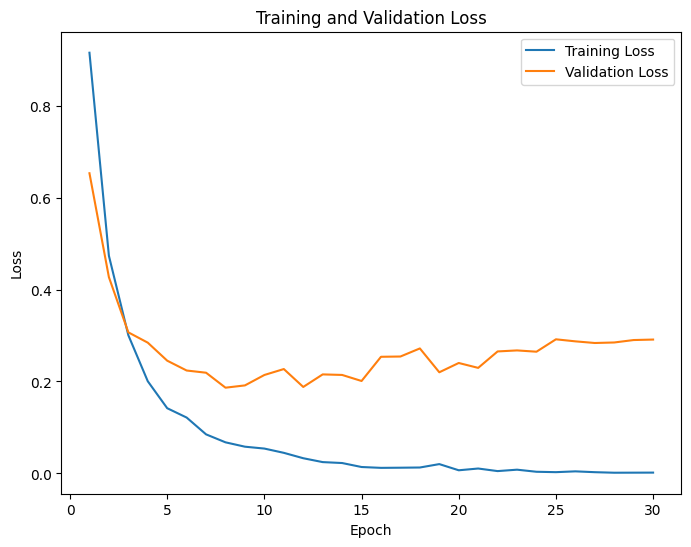

In [114]:
probs = model.predict(val_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(val_labels, predicted_labels, average='macro')

print(f'Validation f1-score: {f1_score1}')

probs = model.predict(train_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(train_labels, predicted_labels, average='macro')

print(f'Train f1-score: {f1_score1}')

plot_loss(history)

Correcion:

In [115]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))  

#regularizamos la lstm
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True,recurrent_regularizer= 'l2', dropout=0.6,recurrent_dropout=0.6)))  
model.add(GlobalMaxPooling1D())  
model.add(Dropout(0.6))
model.add(Dense(22, activation='softmax'))  
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 200

history = model.fit(
    train_pad_sequences, train_encoded_labels,
    batch_size=batch_size, epochs=epochs,
    validation_data=(val_pad_sequences, val_encoded_labels),
    callbacks=[early_stopping]
)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.6636 - loss: 3.5058 - val_accuracy: 0.7556 - val_loss: 1.0225
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.8257 - loss: 0.8127 - val_accuracy: 0.8900 - val_loss: 0.4926
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9107 - loss: 0.4085 - val_accuracy: 0.9267 - val_loss: 0.3478
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9342 - loss: 0.3034 - val_accuracy: 0.9422 - val_loss: 0.2701
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9578 - loss: 0.2123 - val_accuracy: 0.9544 - val_loss: 0.2316
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9597 - loss: 0.1908 - val_accuracy: 0.9567 - val_loss: 0.2281
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9723 - loss: 0.1345 - val_accuracy: 0.9622 - val_loss: 0.2035
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9790 - loss: 0.11

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Validation f1-score: 0.7846224443972117
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Train f1-score: 0.8402345825146228


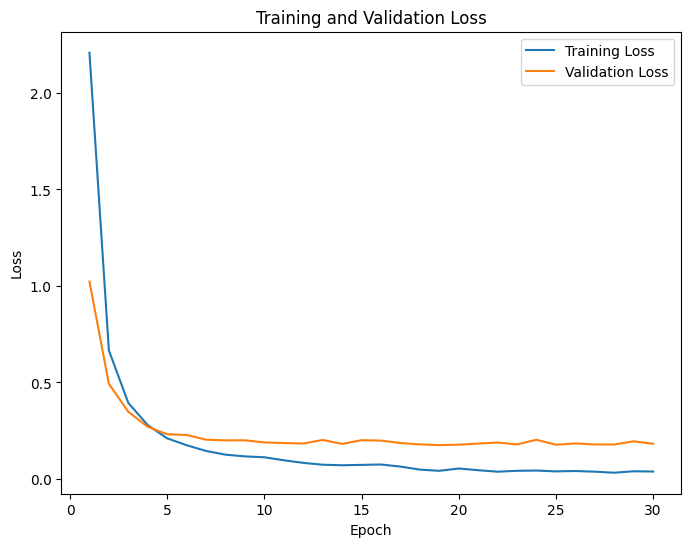

In [116]:
probs = model.predict(val_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(val_labels, predicted_labels, average='macro')

print(f'Validation f1-score: {f1_score1}')

probs = model.predict(train_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(train_labels, predicted_labels, average='macro')

print(f'Train f1-score: {f1_score1}')

plot_loss(history)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7150 - loss: 3.4704 - val_accuracy: 0.7533 - val_loss: 1.0458
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8065 - loss: 0.8518 - val_accuracy: 0.8811 - val_loss: 0.5685
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8843 - loss: 0.4937 - val_accuracy: 0.9178 - val_loss: 0.3872
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9182 - loss: 0.3547 - val_accuracy: 0.9356 - val_loss: 0.3033
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9542 - loss: 0.2222 - val_accuracy: 0.9511 - val_loss: 0.2636
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9577 - loss: 0.1967 - val_accuracy: 0.9567 - val_loss: 0.2388
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9660 - loss: 0.1582 - val_accuracy: 0.9611 - val_loss: 0.2200
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9758 - loss: 0.1351 -

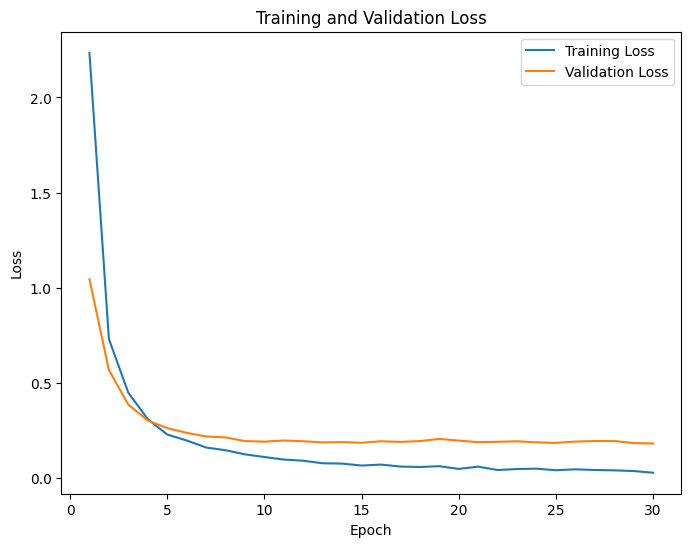

In [117]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))  

#regularizamos la lstm
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True,recurrent_regularizer= 'l2', dropout=0.6,recurrent_dropout=0.6)))  
model.add(GlobalMaxPooling1D())  
model.add(Dropout(0.6))
model.add(Dense(22, activation='softmax'))  
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 200

history = model.fit(
    train_pad_sequences, train_encoded_labels,
    batch_size=batch_size, epochs=epochs,
    validation_data=(val_pad_sequences, val_encoded_labels),
    callbacks=[early_stopping]
)

probs = model.predict(val_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(val_labels, predicted_labels, average='macro')

print(f'Validation f1-score: {f1_score1}')

probs = model.predict(train_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(train_labels, predicted_labels, average='macro')

print(f'Train f1-score: {f1_score1}')

plot_loss(history)

## Experiment 6: Balancejat de Clases

C:\Users\lukag\AppData\Local\Temp\ipykernel_16432\2766925829.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="pastel")


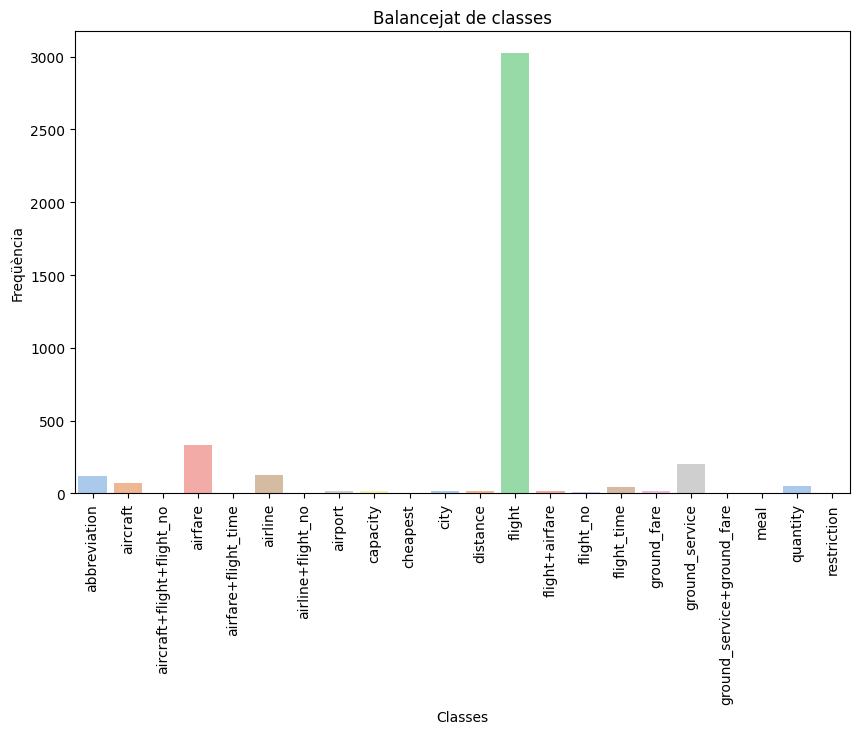

abbreviation: 120
aircraft: 68
aircraft+flight+flight_no: 1
airfare: 333
airfare+flight_time: 1
airline: 125
airline+flight_no: 2
airport: 14
capacity: 13
cheapest: 1
city: 16
distance: 15
flight: 3023
flight+airfare: 15
flight_no: 11
flight_time: 46
ground_fare: 15
ground_service: 203
ground_service+ground_fare: 1
meal: 3
quantity: 50
restriction: 2


In [118]:
#ver que tan balancejats estan las clases del dataset train
unique, counts = np.unique(train_labels, return_counts=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=unique, y=counts, palette="pastel")
plt.title('Balancejat de classes')
plt.xlabel('Classes')
plt.ylabel('Freqüència')
plt.xticks(rotation=90)
plt.show()

class_counts = dict(zip(unique, counts))

for class_name, count in class_counts.items():
    print(f'{class_name}: {count}')









In [119]:
# crear class_weights para dar más peso a las clases menos frecuentes en el model.fit. usando sklearn 

weights = compute_class_weight(class_weight='balanced',classes= np.unique(train_numerical_labels),y= train_numerical_labels)

class_weights = dict(zip(np.unique(train_numerical_labels), weights))
print(class_weights)

{0: 1.5446969696969697, 1: 2.7259358288770055, 2: 185.36363636363637, 3: 0.5566475566475566, 4: 185.36363636363637, 5: 1.482909090909091, 6: 92.68181818181819, 7: 13.24025974025974, 8: 14.258741258741258, 9: 185.36363636363637, 10: 11.585227272727273, 11: 12.357575757575757, 12: 0.06131777583977385, 13: 12.357575757575757, 14: 16.85123966942149, 15: 4.029644268774703, 16: 12.357575757575757, 17: 0.9131213613972234, 18: 185.36363636363637, 19: 61.78787878787879, 20: 3.707272727272727, 21: 92.68181818181819}


Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.2009 - loss: 4.7081 - val_accuracy: 0.7633 - val_loss: 3.1565
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.3576 - loss: 3.6006 - val_accuracy: 0.7556 - val_loss: 3.0076
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6048 - loss: 2.8076 - val_accuracy: 0.3078 - val_loss: 2.5224
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.3696 - loss: 3.2011 - val_accuracy: 0.4133 - val_loss: 2.2299
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.4545 - loss: 2.0941 - val_accuracy: 0.7822 - val_loss: 1.9062
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.6361 - loss: 2.7288 - val_accuracy: 0.7756 - val_loss: 1.6040
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.6599 - loss: 1.9982 - val_accuracy: 0.7700 - val_loss: 1.4704
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7035 - loss: 2.0711 -

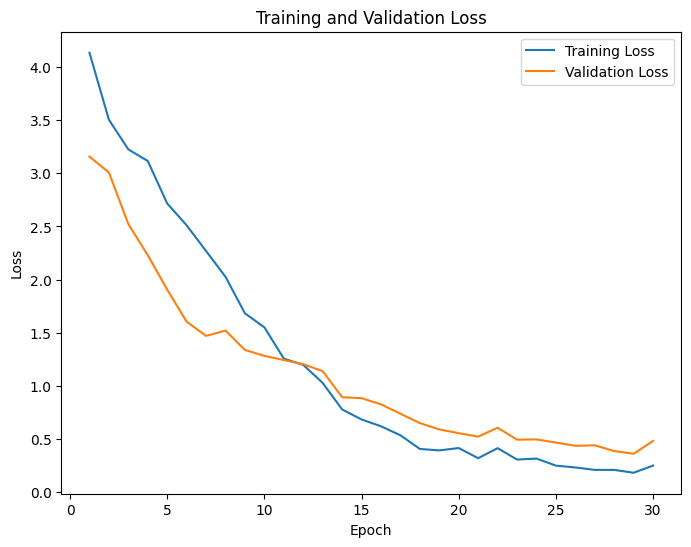

In [120]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))  

#regularizamos la lstm
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True,recurrent_regularizer= 'l2', dropout=0.6,recurrent_dropout=0.6)))  
model.add(GlobalMaxPooling1D())  
model.add(Dropout(0.6))
model.add(Dense(22, activation='softmax'))  
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 200

history = model.fit(
    train_pad_sequences, train_encoded_labels,
    batch_size=batch_size, epochs=epochs,
    validation_data=(val_pad_sequences, val_encoded_labels),
    callbacks=[early_stopping], class_weight=class_weights
)

probs = model.predict(val_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(val_labels, predicted_labels, average='macro')

print(f'Validation f1-score: {f1_score1}')

probs = model.predict(train_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(train_labels, predicted_labels, average='macro')

print(f'Train f1-score: {f1_score1}')

plot_loss(history)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.0626 - loss: 4.8411 - val_accuracy: 0.7122 - val_loss: 2.8110
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7049 - loss: 2.5772 - val_accuracy: 0.8033 - val_loss: 1.6073
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.7984 - loss: 1.5103 - val_accuracy: 0.7278 - val_loss: 1.3556
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7778 - loss: 1.1614 - val_accuracy: 0.8422 - val_loss: 0.8633
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8690 - loss: 0.5598 - val_accuracy: 0.8600 - val_loss: 0.7218
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8826 - loss: 0.2612 - val_accuracy: 0.9256 - val_loss: 0.4073
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9248 - loss: 0.1849 - val_accuracy: 0.9111 - val_loss: 0.4077
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9345 - loss: 0.1264 -

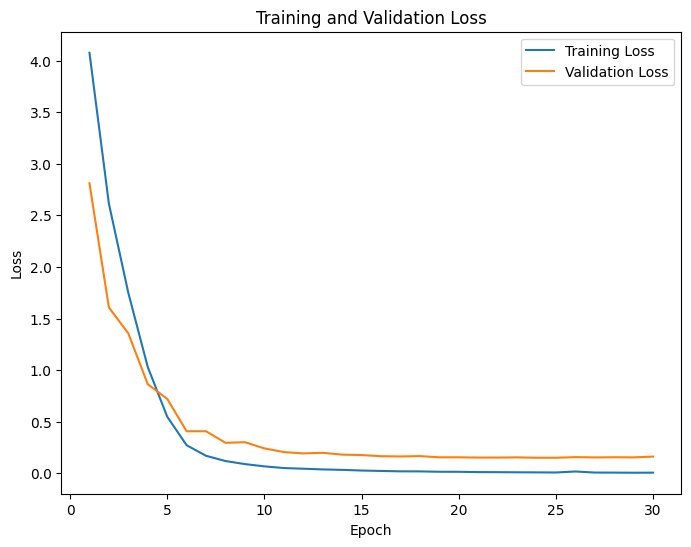

In [121]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))  

#regularizamos la lstm
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True,recurrent_regularizer= 'l2')))    
model.add(GlobalMaxPooling1D())  
model.add(Dense(22, activation='softmax'))  
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 200

history = model.fit(
    train_pad_sequences, train_encoded_labels,
    batch_size=batch_size, epochs=epochs,
    validation_data=(val_pad_sequences, val_encoded_labels),
    callbacks=[early_stopping], class_weight=class_weights
)

probs = model.predict(val_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(val_labels, predicted_labels, average='macro')

print(f'Validation f1-score: {f1_score1}')

probs = model.predict(train_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(train_labels, predicted_labels, average='macro')

print(f'Train f1-score: {f1_score1}')

plot_loss(history)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.1255 - loss: 4.5376 - val_accuracy: 0.5378 - val_loss: 3.0739
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.6504 - loss: 2.5975 - val_accuracy: 0.2289 - val_loss: 2.5727
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.2786 - loss: 2.3102 - val_accuracy: 0.7311 - val_loss: 1.9991
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.6711 - loss: 1.9391 - val_accuracy: 0.8111 - val_loss: 1.2382
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.8064 - loss: 1.2027 - val_accuracy: 0.8444 - val_loss: 0.9777
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8492 - loss: 0.8715 - val_accuracy: 0.7989 - val_loss: 0.9971
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.8397 - loss: 0.7597 - val_accuracy: 0.8433 - val_loss: 0.7298
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8823 - loss: 0.3698 -

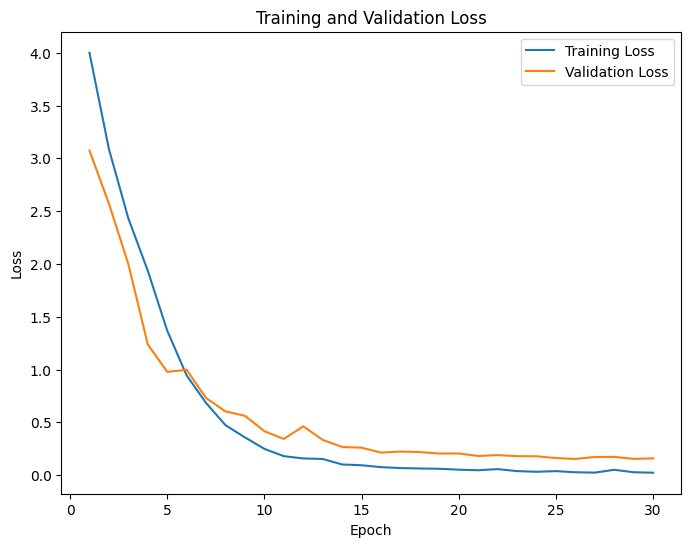

In [122]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))  

#regularizamos la lstm
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True,recurrent_regularizer= 'l2', dropout=0.6)))    
model.add(GlobalMaxPooling1D())  
model.add(Dense(22, activation='softmax'))  
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 200

history = model.fit(
    train_pad_sequences, train_encoded_labels,
    batch_size=batch_size, epochs=epochs,
    validation_data=(val_pad_sequences, val_encoded_labels),
    callbacks=[early_stopping], class_weight=class_weights
)

probs = model.predict(val_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(val_labels, predicted_labels, average='macro')

print(f'Validation f1-score: {f1_score1}')

probs = model.predict(train_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)
f1_score1 = f1_score(train_labels, predicted_labels, average='macro')

print(f'Train f1-score: {f1_score1}')

plot_loss(history)


<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---